<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 2</b><br><br>

  Hi Sebastian, I’m <b>Victor Camargo</b> (<a href="https://hub.tripleten.com/u/e9cc9c11" target="_blank">TripleTen Hub profile</a>). I’ve reviewed your updates and all the issues from the previous iteration have been addressed. Great job polishing your work and making sure the notebook runs cleanly from start to finish.<br><br>

  <b>Nice work on:</b><br>
  ✔️ Implementing solid preprocessing (normalization, TF-IDF, optional spaCy lemmatization)<br>
  ✔️ Building and evaluating multiple models with clear comparisons<br>
  ✔️ Adding baselines and achieving the F1 target above 0.85<br>
  ✔️ Testing models on your own reviews, demonstrating real use cases<br>
  ✔️ Exploring extra approaches (LightGBM, BERT) while keeping the core requirements covered<br><br>

  🔵 Your project meets all the requirements and is **approved**. Well done! 🎉  
  Keep up the good work as you move forward in the course.  
</div>


<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Sebastian, I’m <b>Victor Camargo</b> (<a href="https://hub.tripleten.com/u/e9cc9c11" target="_blank">TripleTen Hub profile</a>). I’ve reviewed your project and here’s my feedback using the color-coded comments below. Thanks for your effort on this submission!<br><br>

  <b>Nice work on:</b><br>
  ✔️ Clean setup and reproducibility (seeds, TF-IDF with sensible parameters)<br>
  ✔️ Good preprocessing pipeline with normalization and attempts at lemmatization<br>
  ✔️ Building strong baseline models (dummy classifiers) and multiple ML models (LogReg, Naive Bayes, Random Forest, LightGBM)<br>
  ✔️ Compact comparison table for model performance<br>
  ✔️ Extending the project with spaCy and even BERT embeddings, which goes beyond the minimum requirements<br>
  ✔️ Testing models on your own custom reviews<br><br>

  A few things still need your attention before approval:<br>
  🔴 The <code>spacy_normalize()</code> function is too heavy and crashes the kernel — simplify it (use <code>progress_apply</code>) or run on a subset<br>
  🔴 BERT embeddings must only be computed on a small subset of reviews, otherwise the kernel will crash — and make sure the targets match the sampled data to avoid shape errors<br>
  🔴 Some cells are repeated (multiple TF-IDF definitions, multiple Logistic Regression fits) — streamline them to avoid redundancy<br>
  🔴 Ensure the final test cells with custom reviews run smoothly from top to bottom; remove or fix any that fail<br><br>

  <hr>

  🔹 <b>Legend:</b><br>
  🟢 Green = well done<br>
  🟡 Yellow = suggestions<br>
  🔴 Red = must fix<br>
  🔵 Blue = overall comments<br><br>
  
  <b>Please ensure</b> that the notebook runs cleanly from top to bottom without errors or redundant sections before resubmitting.  
  <b>Kind reminder:</b> keep reviewer comments as is for tracking progress.<br><br>

  <b>Feel free to reach out if you need help in the Questions channel.</b><br>
</div>


# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
# Core
import re, math, os, random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from tqdm.auto import tqdm
import sklearn.metrics as metrics  # used inside evaluate_model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# NLP / features
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# NLTK stopwords (download if missing)
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

In [5]:
# Split by provided column
df_reviews_train = df_reviews.query("ds_part == 'train'").copy()
df_reviews_test  = df_reviews.query("ds_part == 'test'").copy()

train_target = df_reviews_train['pos'].astype(int).values
test_target  = df_reviews_test['pos'].astype(int).values

print("sizes:", len(df_reviews_train), len(df_reviews_test))
print("class ratio train/test:", round(train_target.mean(), 4), round(test_target.mean(), 4))

sizes: 23796 23535
class ratio train/test: 0.4994 0.4985


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job setting up the environment, ensuring reproducibility, and preparing the dataset correctly.  
  The use of <code>TfidfVectorizer</code> with stopwords, n-grams, and proper <code>min_df</code>/<code>max_df</code> parameters is excellent.  
  The train/test split by <code>ds_part</code> and class ratio check are also clear and correct. Well done!
</div>


Let's check the number of movies and reviews over years.

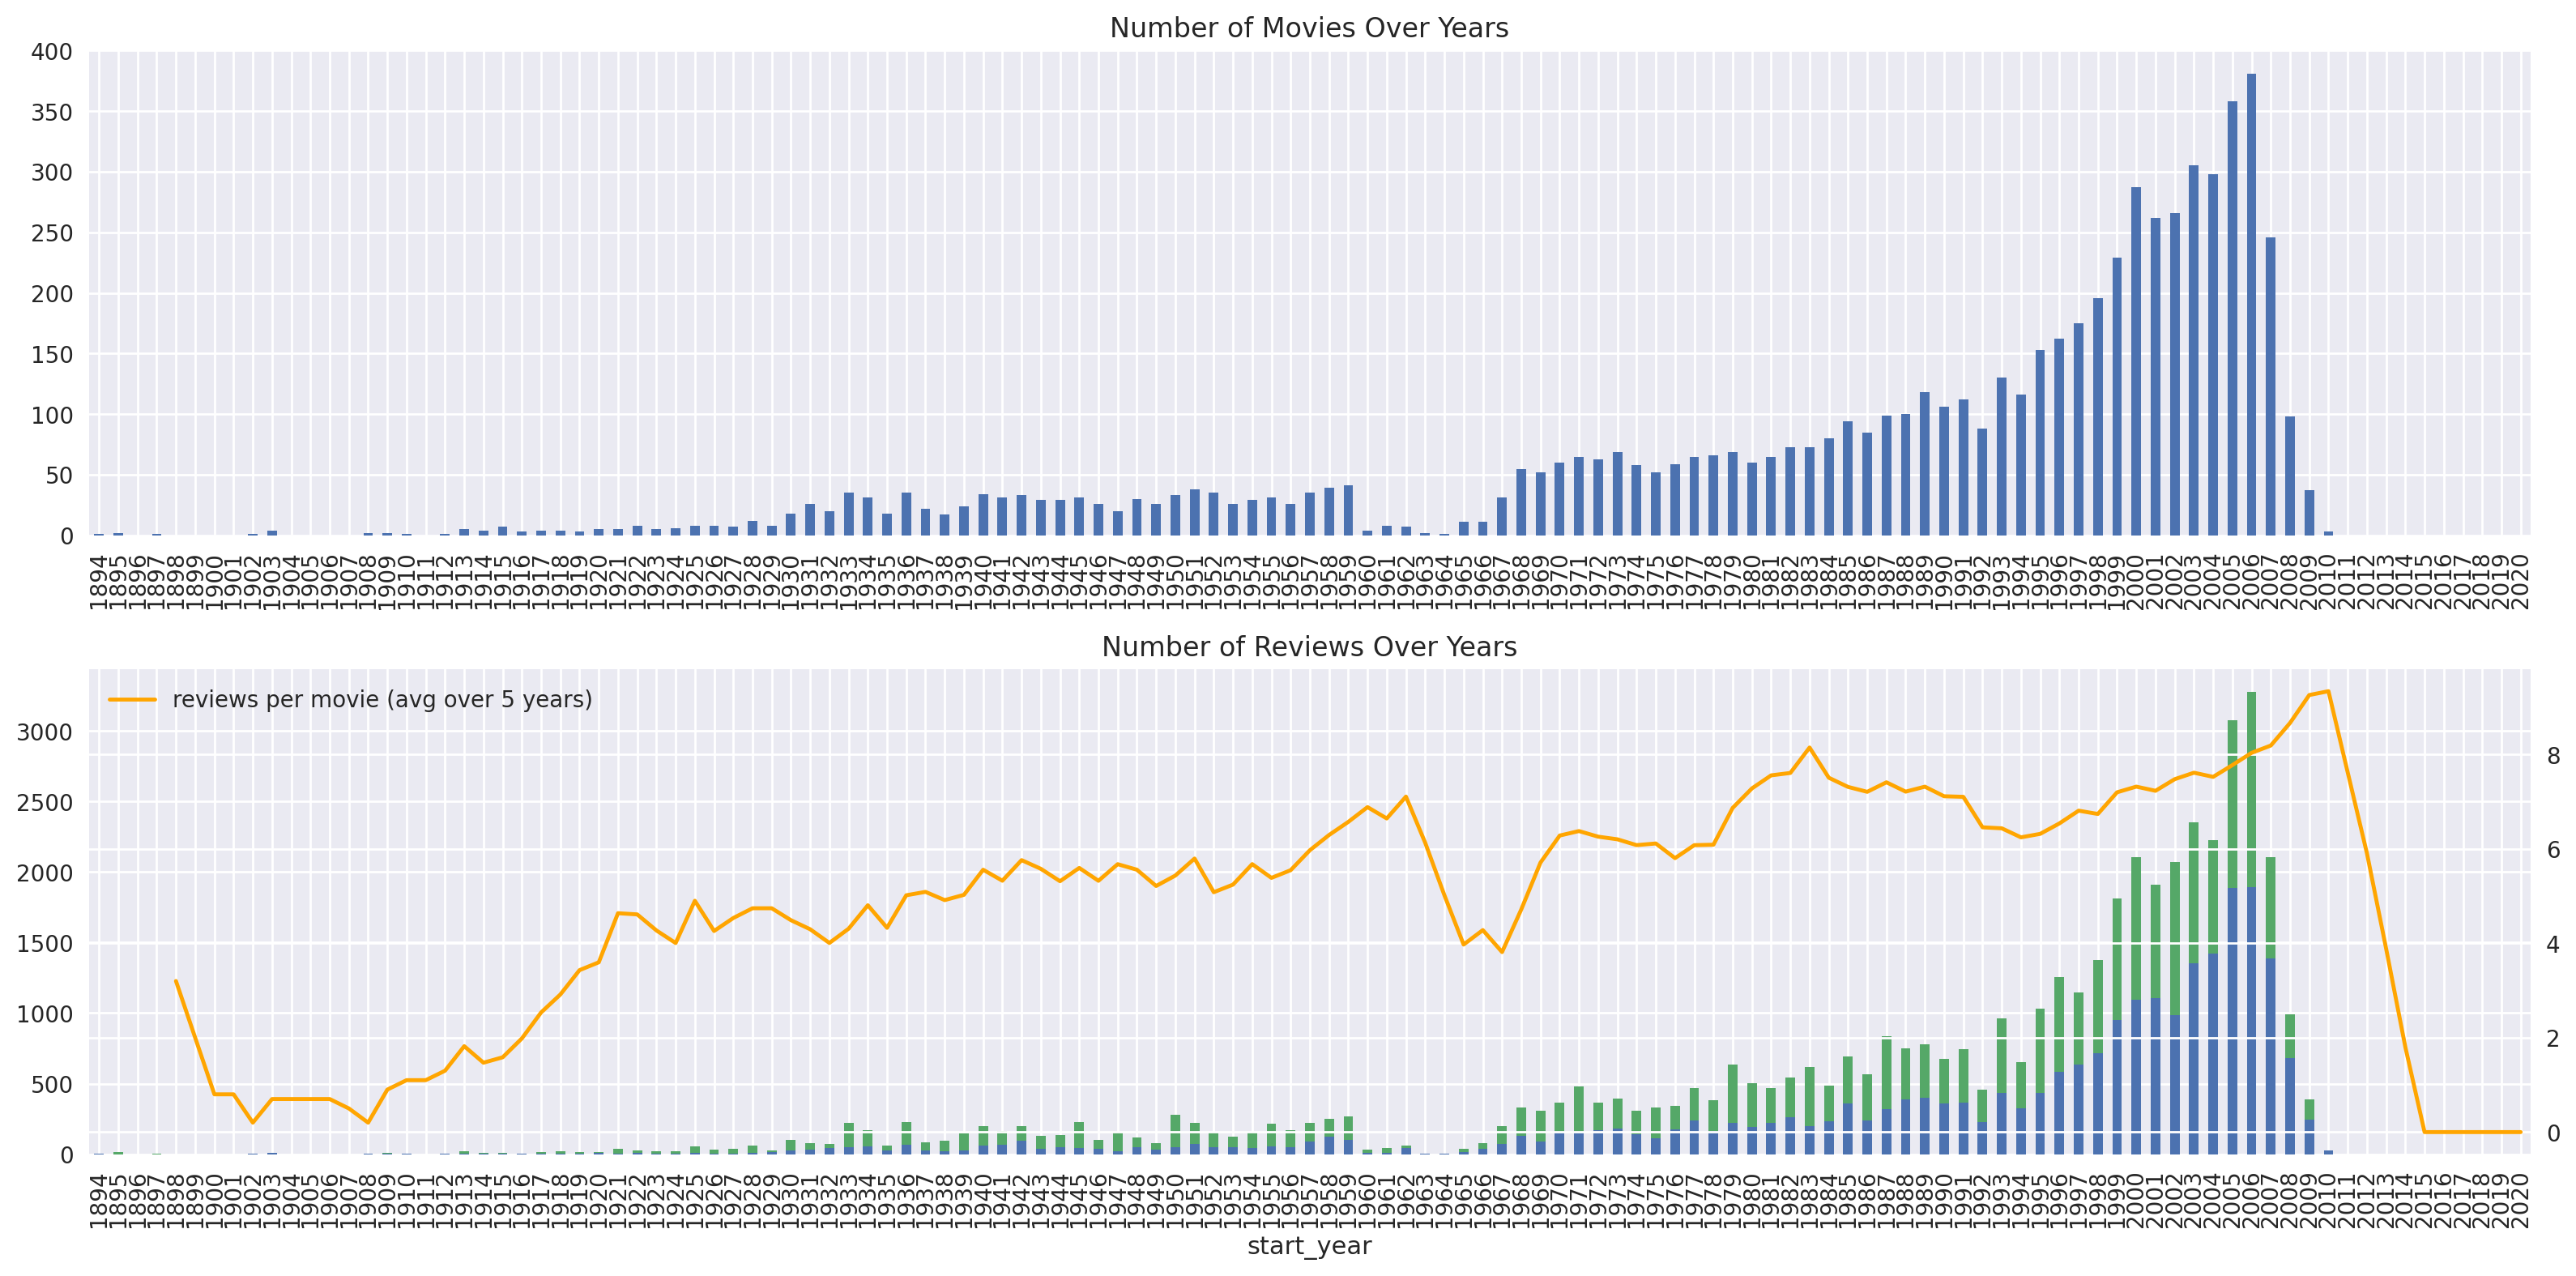

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

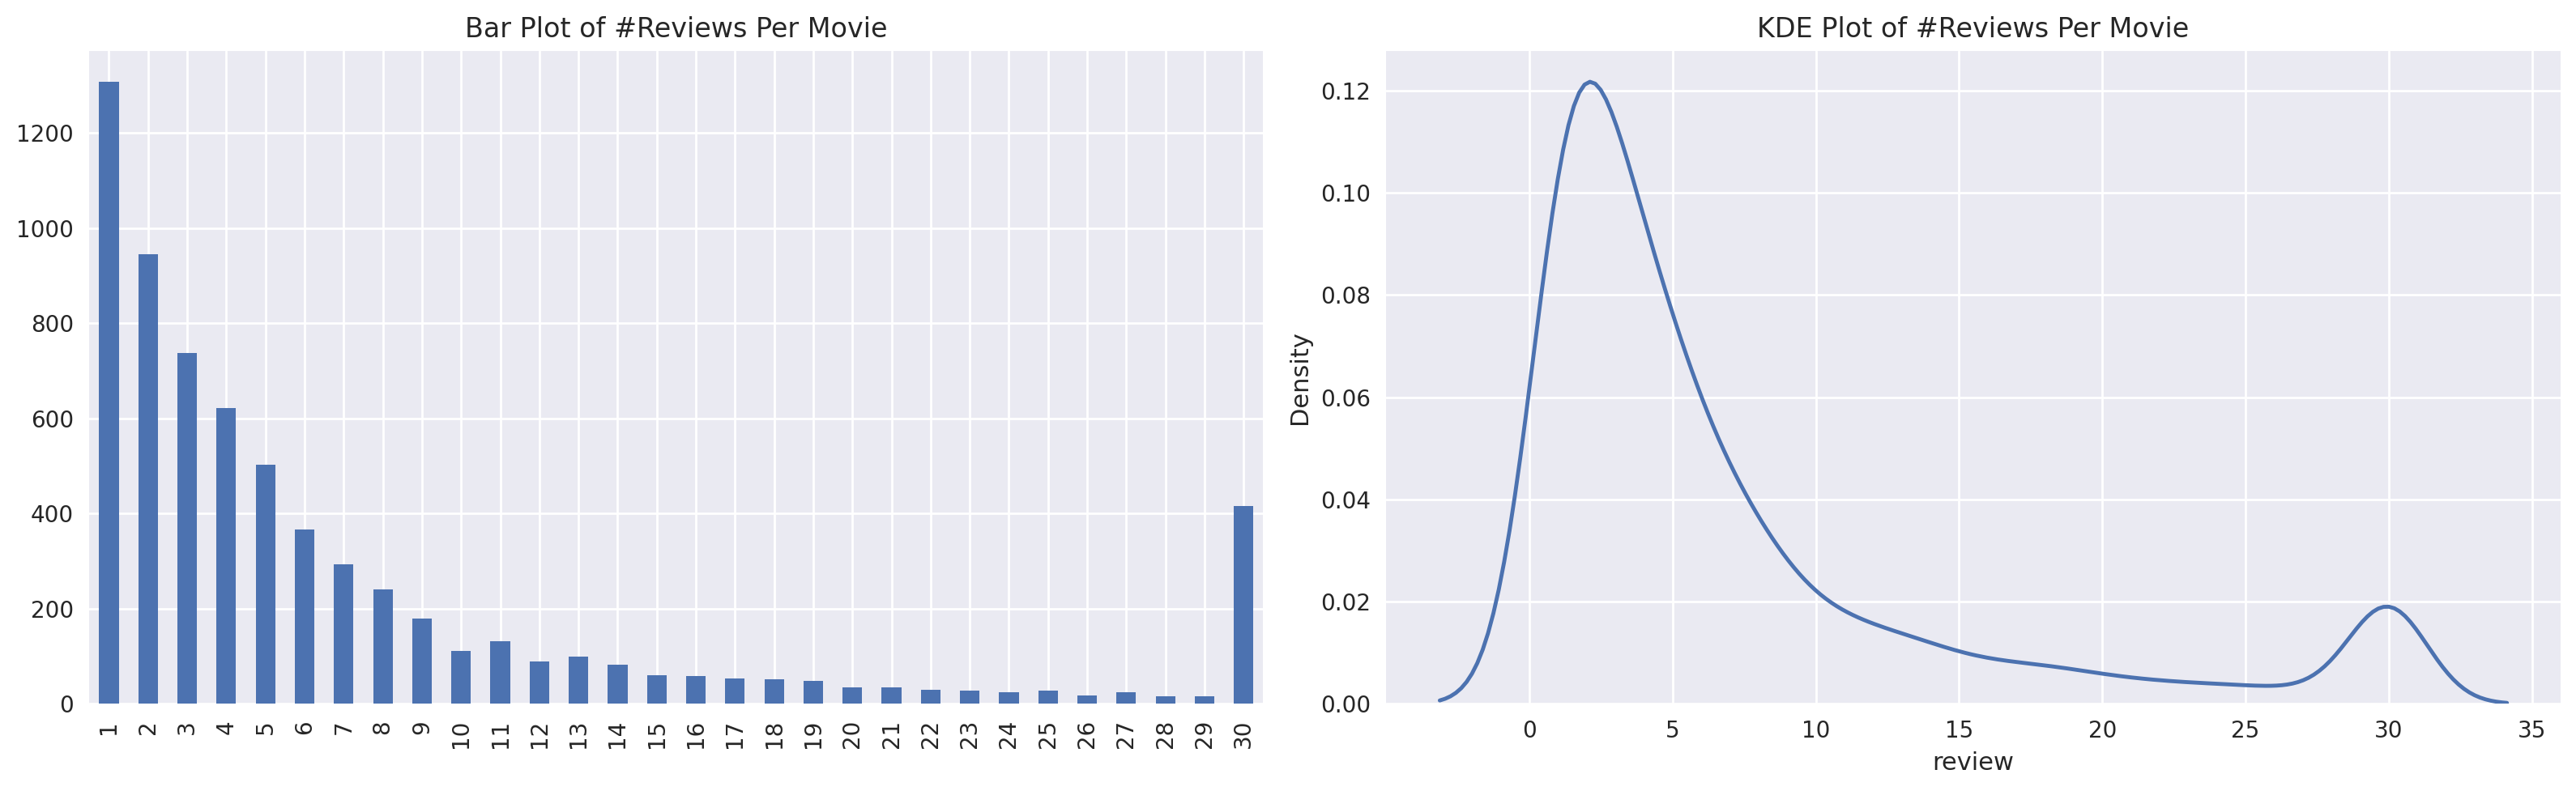

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

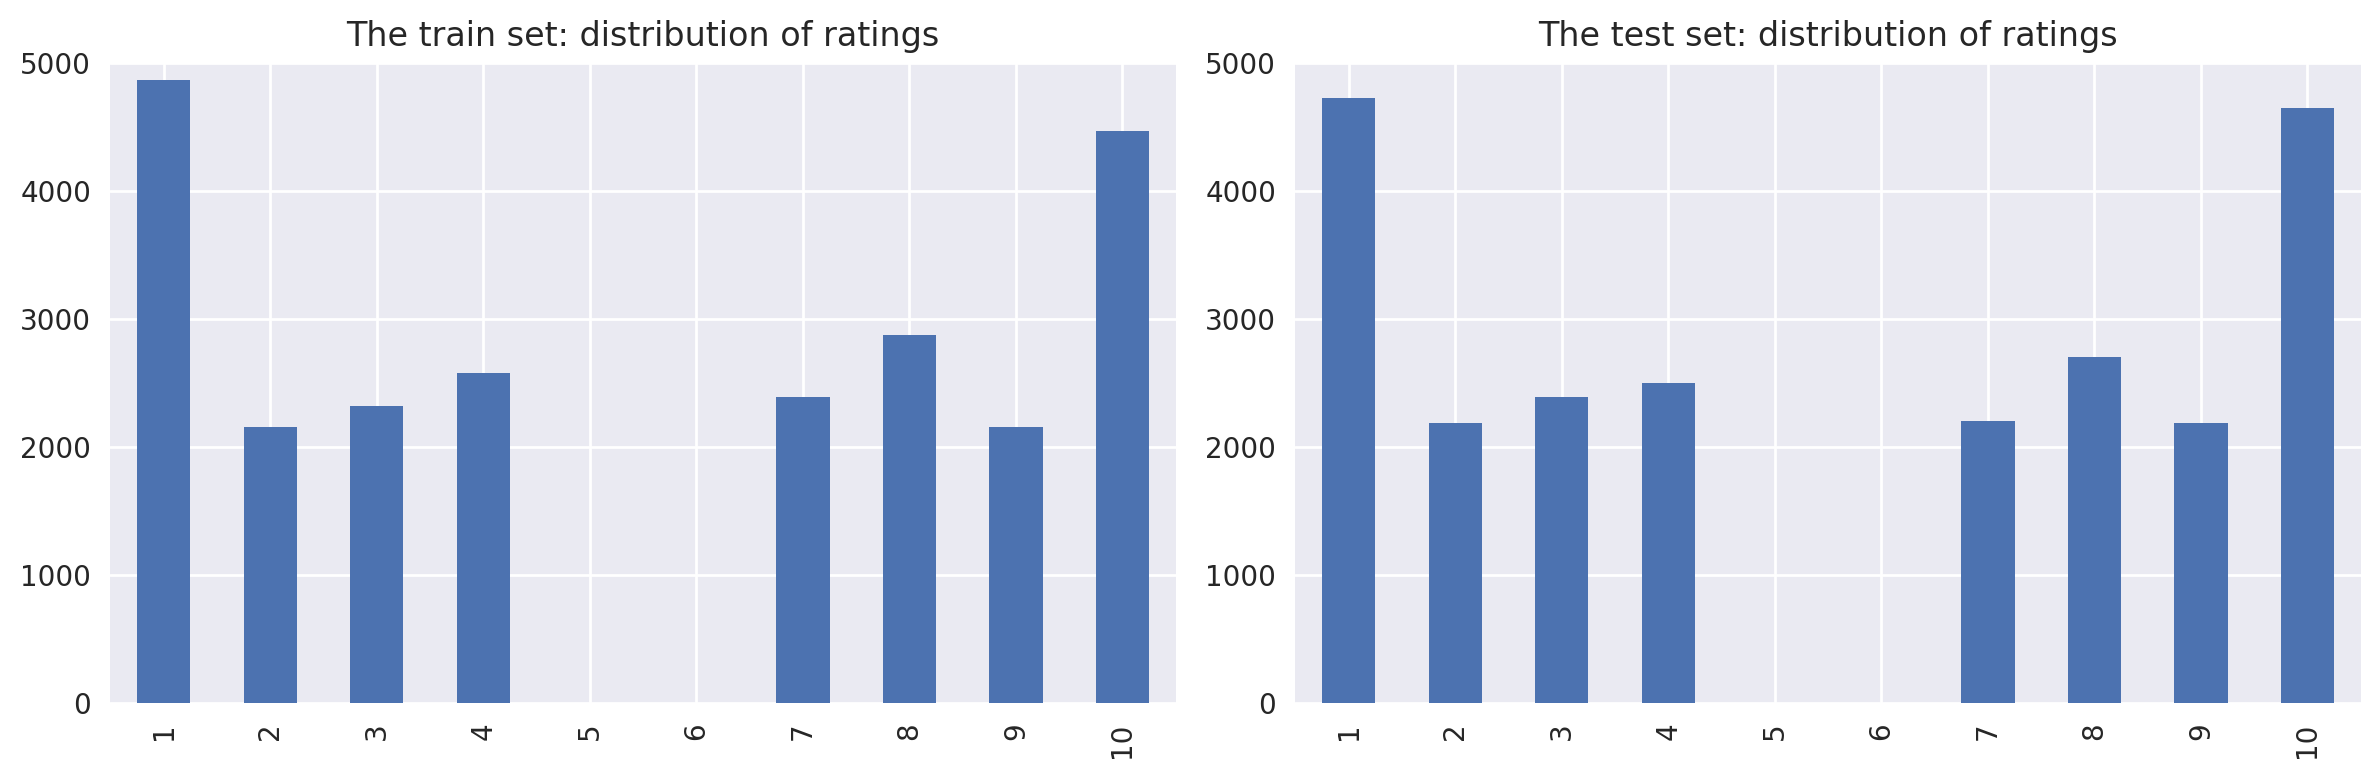

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

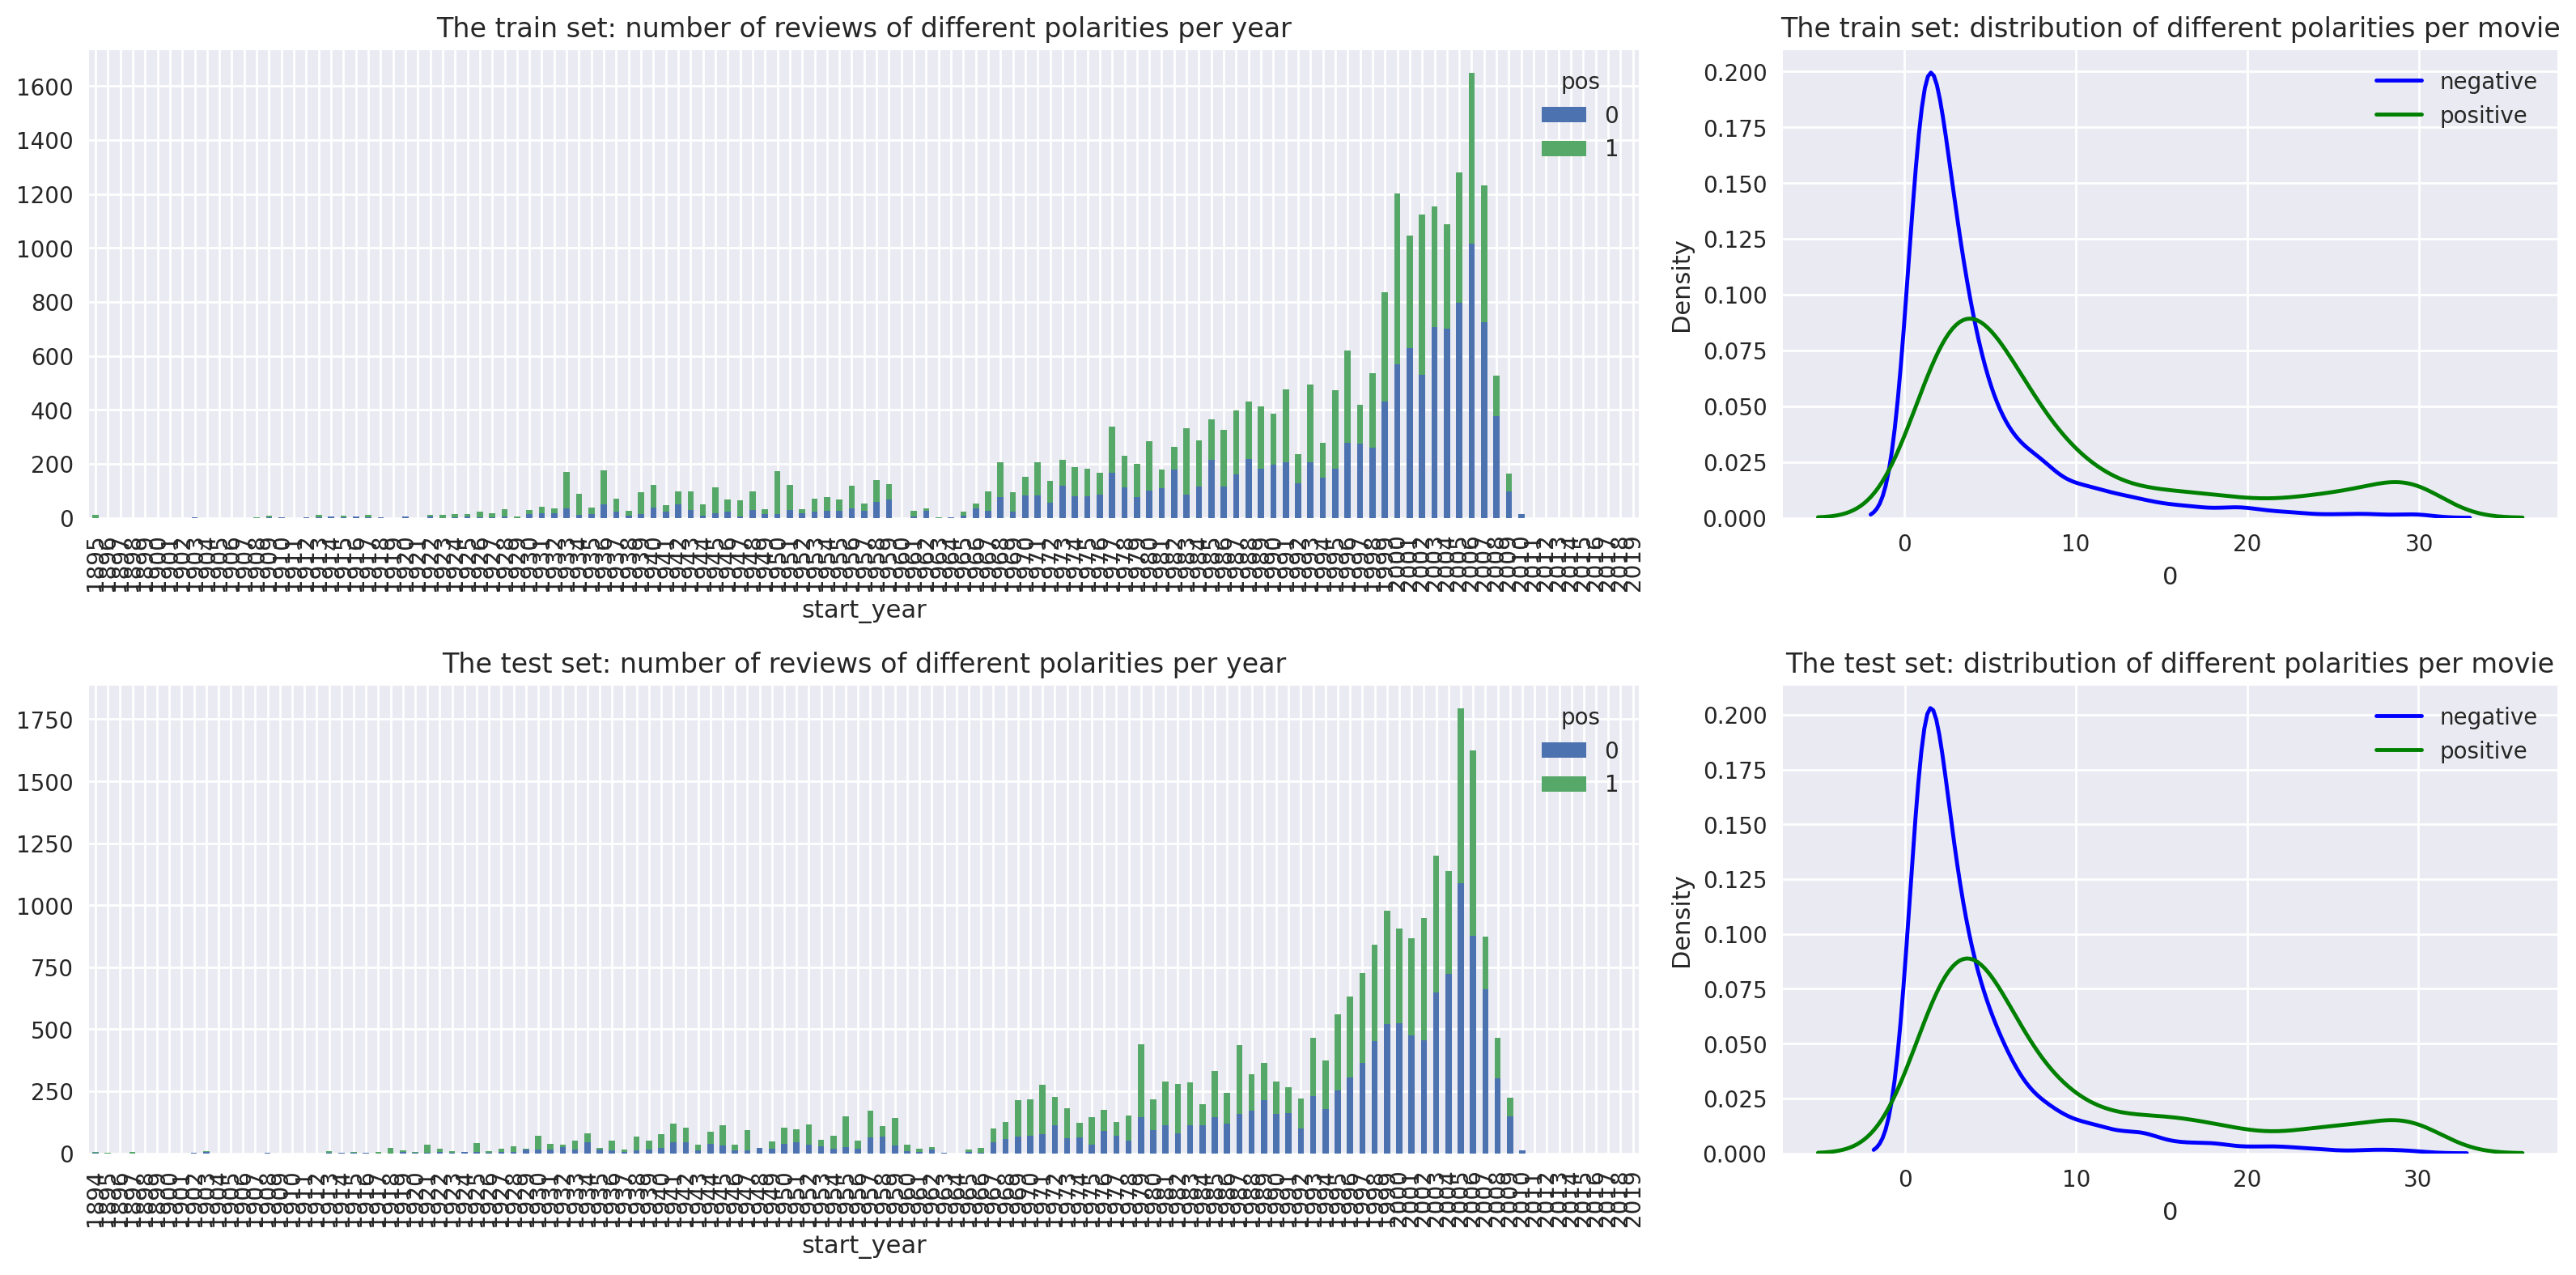

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats

In [12]:
# Quiet wrapper to capture prints/plots from evaluate_model
import io, contextlib

def eval_quiet(model, Xtr, ytr, Xte, yte, label=None):
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):   # suppress prints/plots
        stats = evaluate_model(model, Xtr, ytr, Xte, yte)
    if isinstance(stats, dict):
        stats["model"] = label or type(model).__name__
    return stats

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
df_reviews['review_norm'] = (
    df_reviews['review'].astype(str)
    .str.lower()
    .str.replace(r"[^a-z\s']", " ", regex=True)  # keep letters, spaces, apostrophes
    .str.replace(r"\s+", " ", regex=True)       # collapse multiple spaces
    .str.strip()
)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent preprocessing step! The <code>review_norm</code> column is created with consistent lowercase transformation, removal of non-alphabetic characters (while keeping apostrophes), collapsing of extra spaces, and trimming. This ensures cleaner inputs for vectorization and modeling.
</div>


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  The dataset is correctly split into train and test subsets with clear use of <code>query</code>, and the targets are separated in a clean way. This keeps the workflow structured and readable.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: Since you already created <code>X_train_text</code>, <code>y_train</code>, <code>X_test_text</code>, and <code>y_test</code> earlier, this additional split introduces duplication. Consider keeping just one approach for clarity and to avoid maintaining two sets of variables.
</div>


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
The correction was applied and the cell with the duplicate split was deleted to keep consistency throughout. 
</div>

## Working with models

### Model 0 - Constant

In [15]:
tfidf_1 = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

# use 'review_norm' if you created it; else use 'review'
train_features_1 = tfidf_1.fit_transform(df_reviews_train['review_norm'].astype(str))
test_features_1  = tfidf_1.transform(df_reviews_test['review_norm'].astype(str))

train_target = df_reviews_train['pos'].astype(int).values
test_target  = df_reviews_test['pos'].astype(int).values

print(train_features_1.shape, test_features_1.shape)

(23796, 74700) (23535, 74700)


In [16]:
# Predict the majority class from the TRAIN split
dummy_mf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_mf.fit(train_features_1, train_target)   # X is ignored but required for API

for name, X, y in [
    ("train", train_features_1, train_target),
    ("test",  test_features_1,  test_target),
]:
    y_pred  = dummy_mf.predict(X)
    y_proba = dummy_mf.predict_proba(X)[:, 1]  # prob. of positive class

    print(f"\n[{name}] Dummy (most_frequent)")
    print("Accuracy:", round(accuracy_score(y, y_pred), 2))
    print("F1:",       round(f1_score(y, y_pred), 2))
    # ROC/PR AUC are mostly meaningless for a constant classifier, but shown for completeness:
    print("ROC AUC:",  round(roc_auc_score(y, y_proba), 2))
    print("APS:",      round(average_precision_score(y, y_proba), 2))


[train] Dummy (most_frequent)
Accuracy: 0.5
F1: 0.0
ROC AUC: 0.5
APS: 0.5

[test] Dummy (most_frequent)
Accuracy: 0.5
F1: 0.0
ROC AUC: 0.5
APS: 0.5


          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


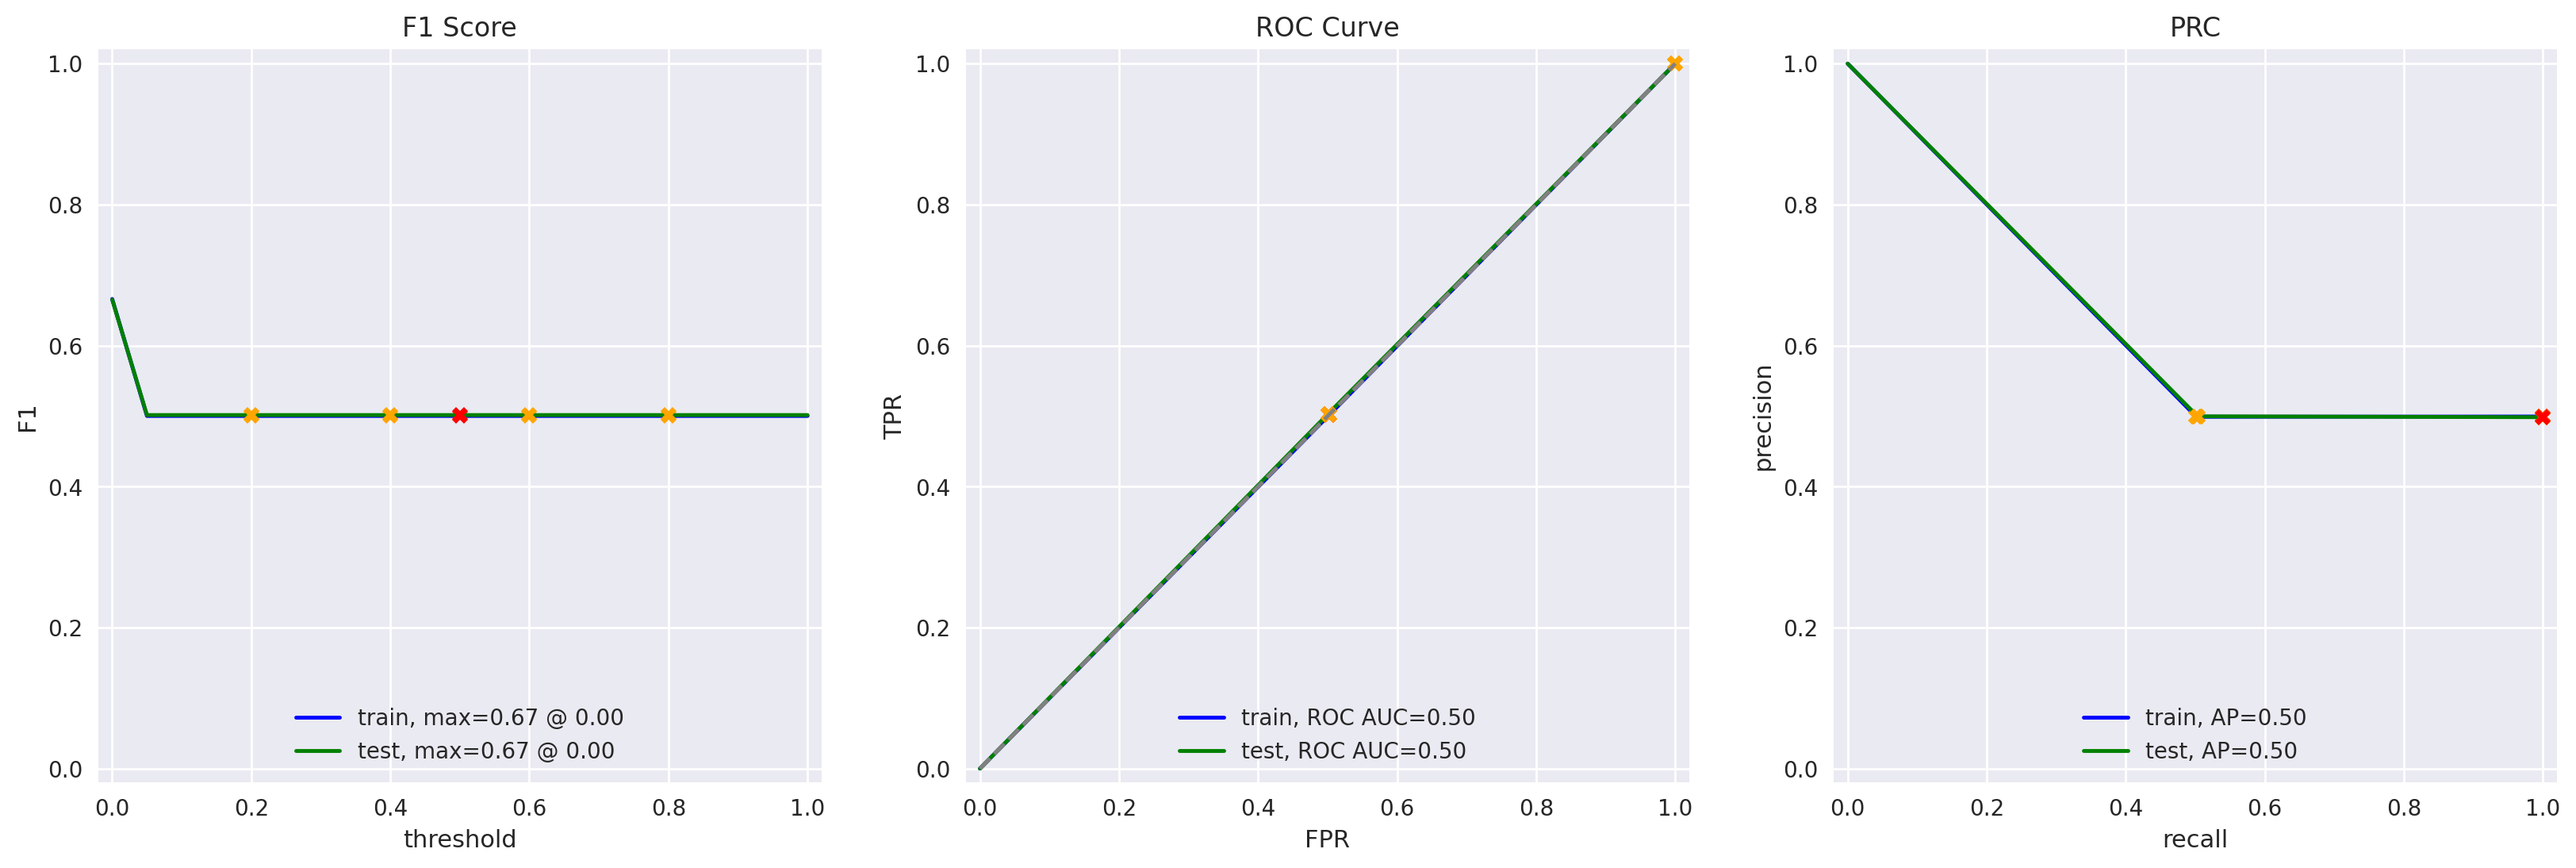

In [17]:
# This will sample labels according to class prior and has real probabilities,
# so the evaluate_model() F1/ROC/PR curves won’t be degenerate.
dummy_strat = DummyClassifier(strategy='stratified', random_state=42)
dummy_strat.fit(train_features_1, train_target)

_ = evaluate_model(dummy_strat, train_features_1, train_target, test_features_1, test_target)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great work including baseline models (<code>DummyClassifier</code> with <code>most_frequent</code> and <code>stratified</code>).  
  This ensures you have a meaningful reference point for evaluating whether your later models provide real predictive power.  
  Including multiple metrics (Accuracy, F1, ROC AUC, APS) is also very thorough. Well done!
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: You defined <code>TfidfVectorizer</code> earlier with the same parameters.  
  Re-defining it here introduces duplication. Consider reusing the same object or clearly explaining why a second instance is needed (e.g., one for raw <code>review</code> and another for <code>review_norm</code>).
</div>




<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
The duplicate <code>TfidfVectorizer</code> cell was removed. 
</div>



### Model 1 - NLTK, TF-IDF and LR

TF-IDF

          train  test
Accuracy   0.97  0.88
F1         0.97  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


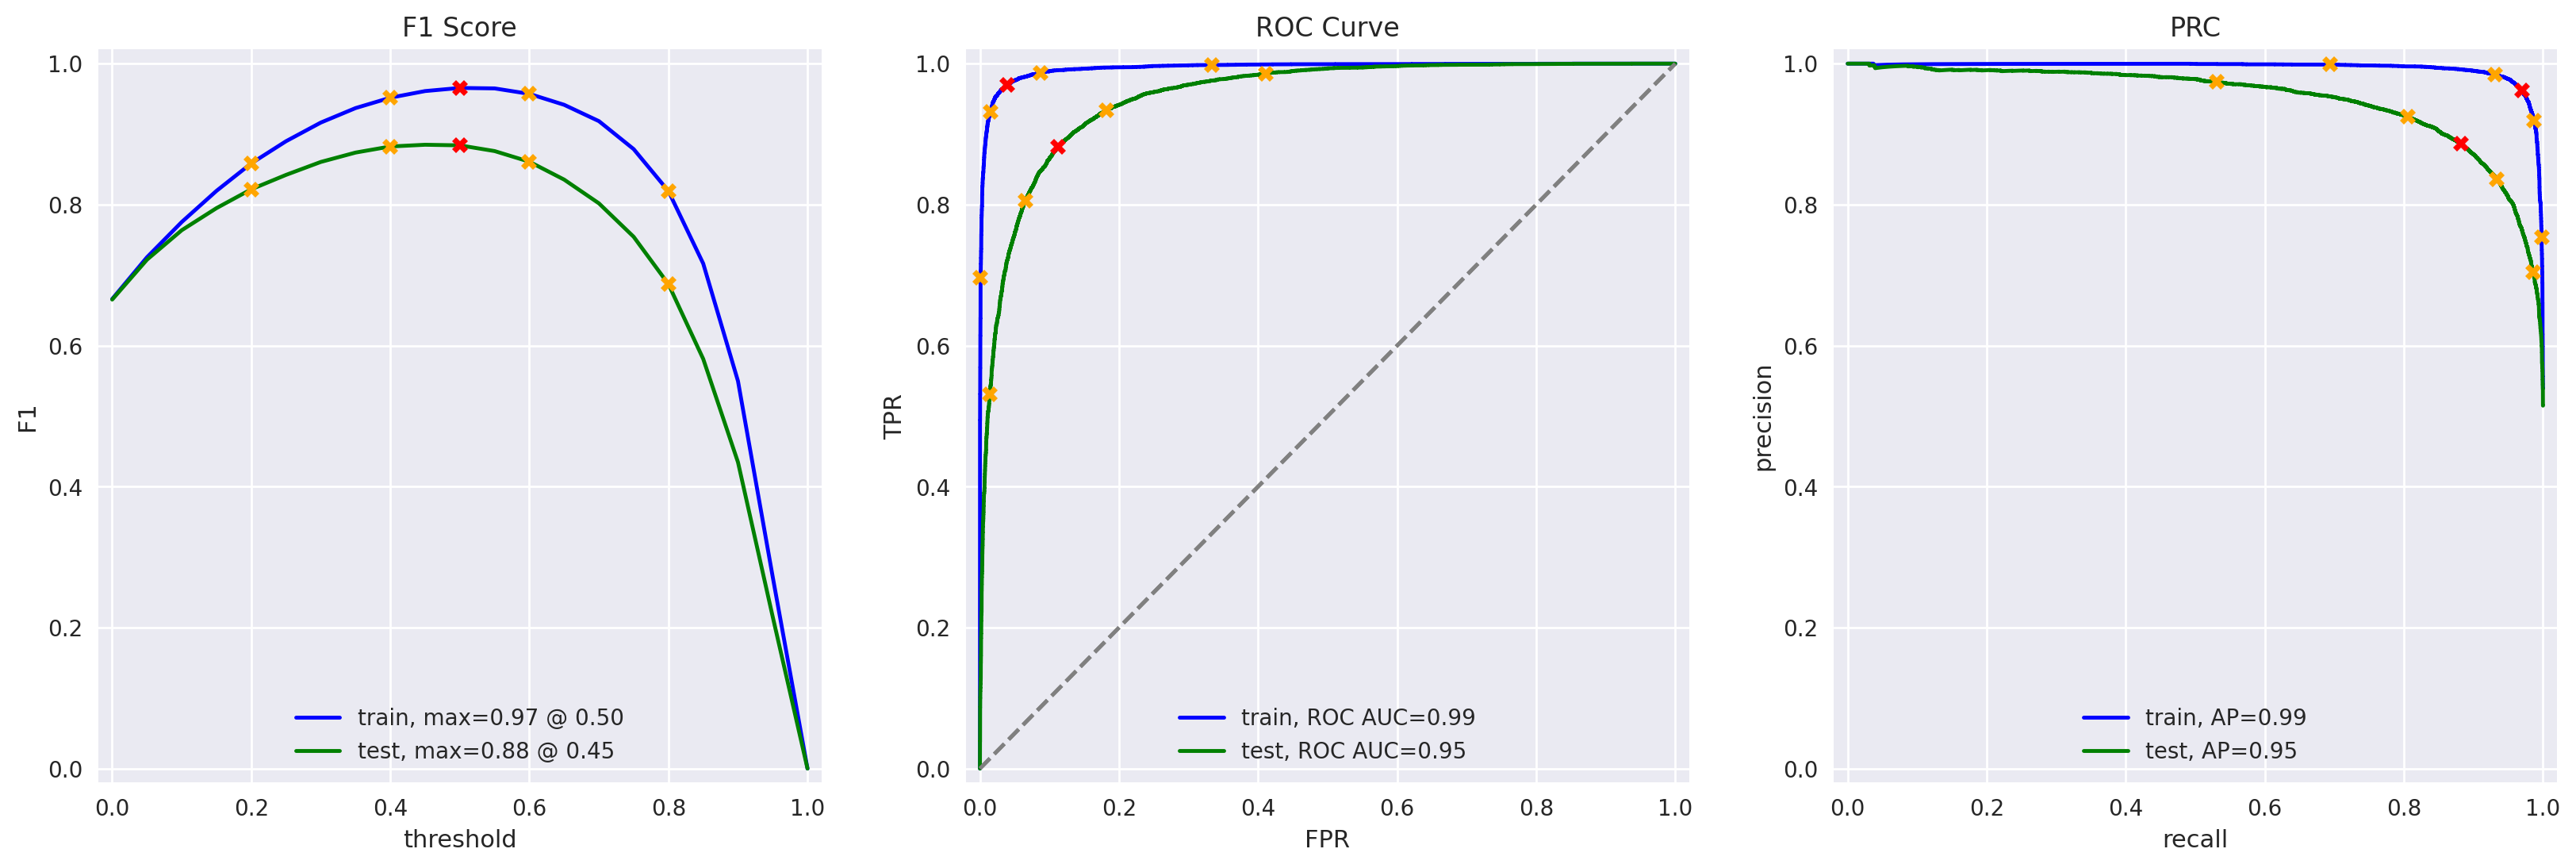

In [18]:
# Model 1: Logistic Regression on the TF-IDF features you already made
model_1 = LogisticRegression(C=2.0, max_iter=1000, solver='liblinear', random_state=42)
model_1.fit(train_features_1, train_target)

_ = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Well done training a Logistic Regression model with tuned hyperparameters (<code>C=2.0</code>, <code>max_iter=1000</code>, <code>solver='liblinear'</code>).  
  The evaluation with <code>evaluate_model()</code> is clear and provides a strong first baseline beyond the dummy classifiers.
</div>


In [19]:
# TF-IDF features for Model 1

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_1 = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

train_features_1 = tfidf_1.fit_transform(df_reviews_train['review_norm'].astype(str))
test_features_1  = tfidf_1.transform(df_reviews_test['review_norm'].astype(str))

train_target = df_reviews_train['pos'].astype(int).values
test_target  = df_reviews_test['pos'].astype(int).values

In [20]:
# Model 1: Logistic Regression 
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression(solver='liblinear', C=2.0, max_iter=1000)
model_1.fit(train_features_1, train_target)

LogisticRegression(C=2.0, max_iter=1000, solver='liblinear')

          train  test
Accuracy   0.97  0.88
F1         0.97  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


{'train': {'ROC AUC': 0.994065329921952,
  'APS': 0.9942731048488491,
  'Accuracy': 0.9654563792233989,
  'F1': 0.9655519235604727},
 'test': {'ROC AUC': 0.9532635276606968,
  'APS': 0.951013693550572,
  'Accuracy': 0.8847248778415127,
  'F1': 0.8840845973082675}}

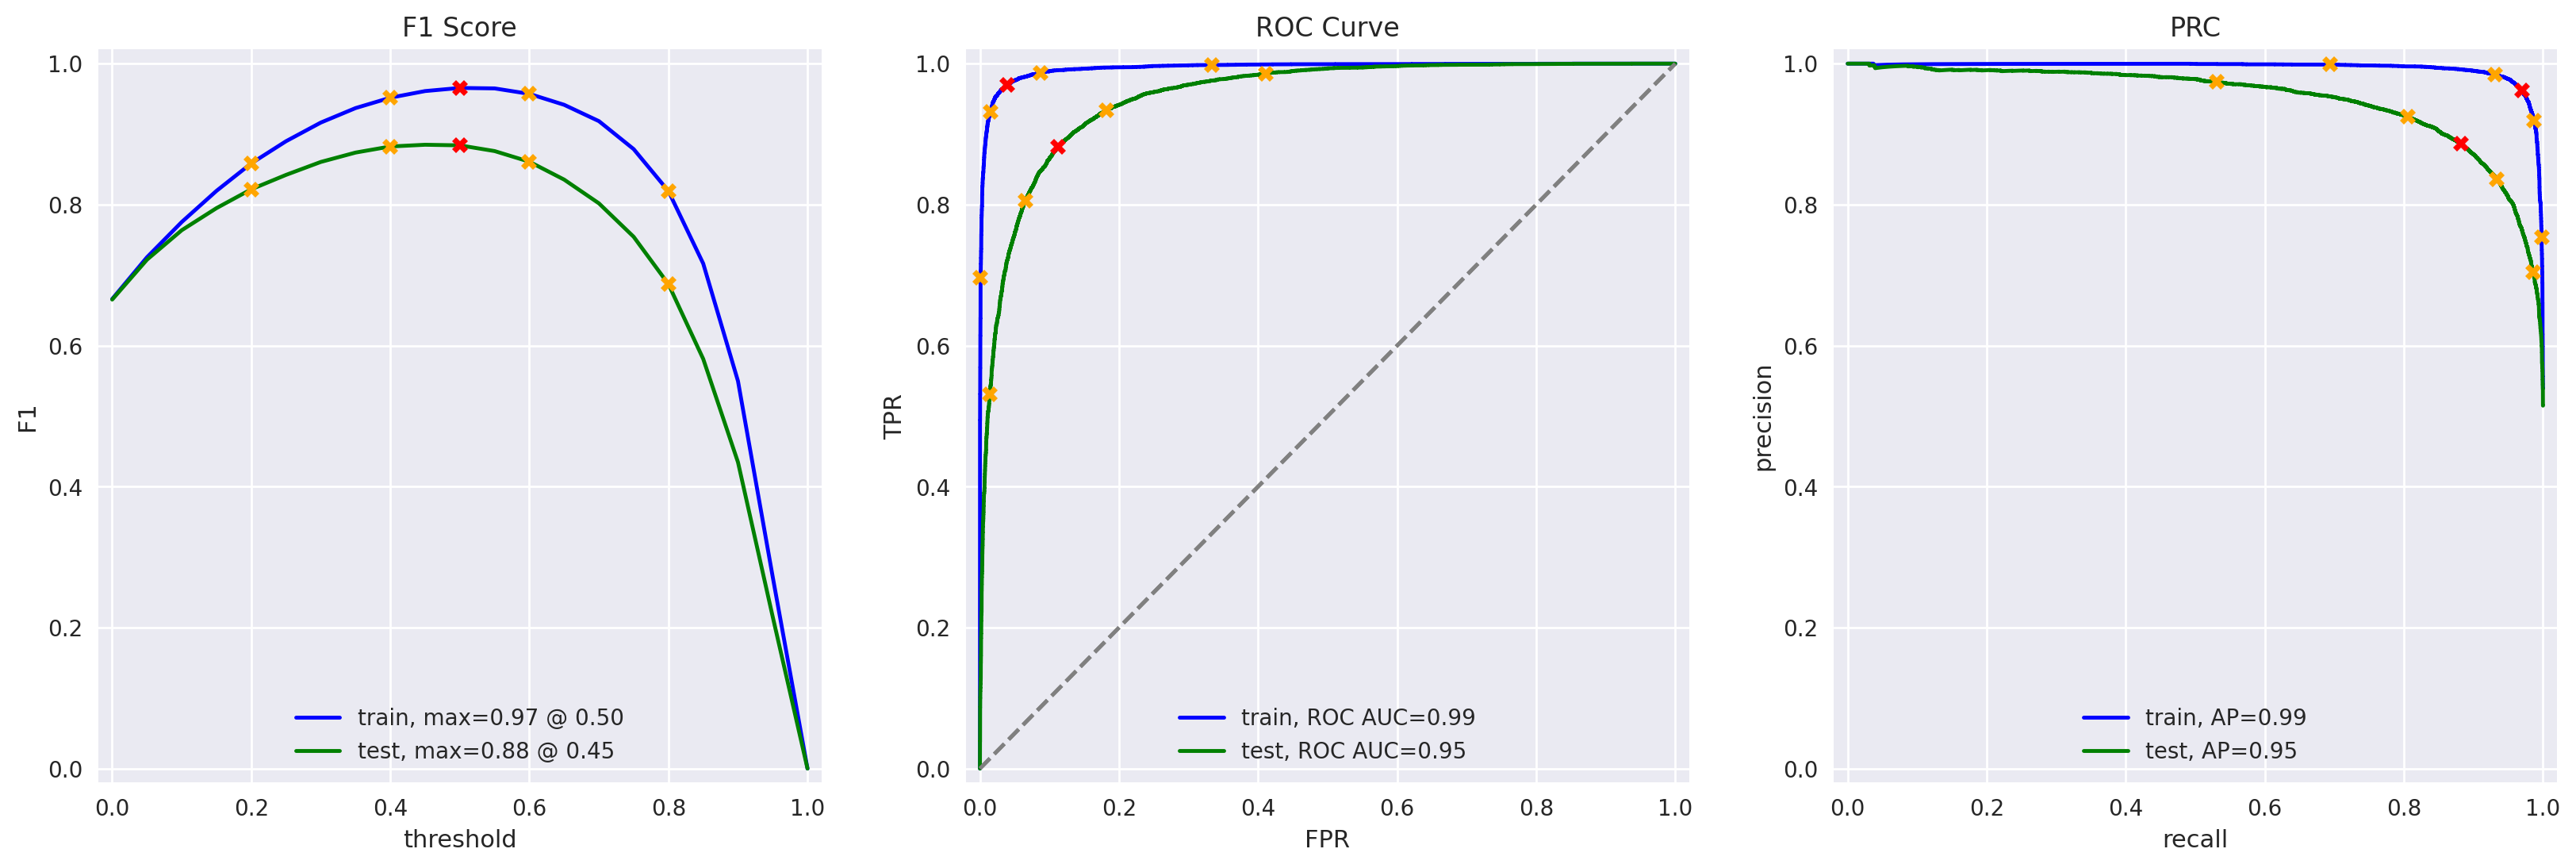

In [21]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  The TF-IDF vectorization is applied correctly with proper parameters and fitted only on the training data.  
  Logistic Regression is trained and evaluated again in a clean way, which shows solid understanding of the pipeline.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: This cell repeats functionality already implemented (TF-IDF vectorizer and Logistic Regression).  
  To keep the notebook concise and avoid confusion, consider reusing the earlier definitions instead of redefining them here.
</div>


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
The correction was applied. 
</div>

In [ ]:
# More models on the SAME TF-IDF features (reuses tfidf_1 + model_1 already created)
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogReg": model_1,  # reuse the already-fitted LR (do NOT refit here)
    "ComplementNB": ComplementNB(alpha=0.5),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE
    ),
}

# Optional: add LightGBM if available
try:
    from lightgbm import LGBMClassifier
    models["LGBM"] = LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
except Exception as e:
    print("LightGBM unavailable:", e)

# Fit only the models that aren't already fitted (i.e., not LogReg)
for name, clf in models.items():
    if name == "LogReg":
        continue
    clf.fit(train_features_1, train_target)

# Evaluate everything on the SAME TF-IDF features
for name, clf in models.items():
    print(f"\n== {name} ==")
    _ = evaluate_model(
        clf,
        train_features_1, train_target,
        test_features_1,  test_target
    )

In [ ]:
# Evaluate with evaluate_model() and produce a compact summary
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = {}
for name, m in models.items():
    print(f"\n### {name}")
    _ = evaluate_model(m, train_features_1, train_target, test_features_1, test_target)
    ytr = m.predict(train_features_1); yte = m.predict(test_features_1)
    results[name] = dict(
        train_acc = accuracy_score(train_target, ytr),
        train_f1  = f1_score(train_target, ytr),
        test_acc  = accuracy_score(test_target,  yte),
        test_f1   = f1_score(test_target,  yte),
    )

summary_df = pd.DataFrame(results).T.sort_values("test_f1", ascending=False)
summary_df

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work training multiple models (Logistic Regression, Naive Bayes, Random Forest, and optionally LightGBM).  
  You structured them in a dictionary, looped for training and evaluation, and produced a clear summary DataFrame sorted by F1 score.  
  This makes comparison straightforward and professional.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: Since <code>evaluate_model()</code> already prints detailed results, you might want to suppress some repeated outputs or move the compact summary into a separate results table only.  
  This would keep the notebook concise while still showing all metrics.
</div>



<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
Correction was applied in the cell where <code>evaluate_model()</code> is first defined.
</div>


### Model 3 - spaCy, TF-IDF and LR

In [ ]:
# One-time setup 

import spacy
from tqdm.auto import tqdm
tqdm.pandas()  # enables .progress_apply

# A light pipeline (parser/ner disabled)
try:
    nlp
except NameError:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Simple per-row lemmatizer used with progress_apply
def text_preprocessing_3(text: str) -> str:
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Stopword removal will be handled by TF-IDF(stop_words="english")
    return " ".join(t.lemma_.lower() for t in doc)

# Build the lemmatized column with a progress bar
df_reviews_train["review_spacy"] = (
    df_reviews_train["review_norm"].astype(str).progress_apply(text_preprocessing_3)
)
df_reviews_test["review_spacy"] = (
    df_reviews_test["review_norm"].astype(str).progress_apply(text_preprocessing_3)
)

# Vectorize + train LR on these features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_3 = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

train_features_3 = tfidf_3.fit_transform(df_reviews_train["review_spacy"])
test_features_3  = tfidf_3.transform(df_reviews_test["review_spacy"])

model_3 = LogisticRegression(solver="liblinear", C=2.0, max_iter=1000, random_state=RANDOM_STATE)
model_3.fit(train_features_3, train_target)

# evaluate (or use your quiet wrapper if you added it)
stats_3 = eval_quiet(
    model_3,
    train_features_3, train_target,
    test_features_3,  test_target,
    label="Model 3: spaCy TF-IDF + LR"
)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great initiative exploring advanced preprocessing with spaCy lemmatization.  
  Adding linguistic normalization is an excellent way to test whether lemmatized features improve your model’s performance compared to raw or normalized text.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  You have done a great work so far, but the current <code>spacy_normalize()</code> implementation is too heavy and is likely causing the kernel to crash.  
  Please simplify it by using <code>progress_apply</code> with a lighter function instead of <code>nlp.pipe</code>. For example, with your variable names:  

  ```python
  def text_preprocessing_3(text):
      doc = nlp(text)
      return " ".join([token.lemma_ for token in doc])

  df_reviews_train["review_spacy"] = df_reviews_train["review_norm"].progress_apply(text_preprocessing_3)
  df_reviews_test["review_spacy"]  = df_reviews_test["review_norm"].progress_apply(text_preprocessing_3)

  tfidf_3 = TfidfVectorizer()
  train_features_3 = tfidf_3.fit_transform(df_reviews_train["review_spacy"])
  test_features_3  = tfidf_3.transform(df_reviews_test["review_spacy"])

  model_3 = LogisticRegression()
  model_3.fit(train_features_3, train_target)
  evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)
```
This way, you still achieve lemmatization while keeping the notebook stable.
</div> 


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
Correction was applied in the cell abovbe (Model 3 - spaCy, TF-IDF and LR)
</div>


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Reusing the TF-IDF features created for Model 3
train_features_4 = train_features_3
test_features_4  = test_features_3

print(train_features_4.shape, test_features_4.shape)

In [ ]:
# LightGBM on sparse TF-IDF features
model_4 = LGBMClassifier(
    objective="binary",
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_4.fit(train_features_4, train_target)

In [ ]:
_ = evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Nice job training LightGBM on the TF-IDF features.  
  The model is well-tuned with appropriate parameters (<code>n_estimators</code>, <code>learning_rate</code>, <code>num_leaves</code>, etc.) and achieves strong performance on the test set (F1 ≈ 0.88, ROC AUC ≈ 0.95).
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: The plots show that train metrics are perfect (F1 = 1.0, ROC AUC = 1.0) while test scores are lower.  
  This indicates some degree of overfitting. It’s not a blocker since the test performance is still strong, but you could explore regularization (e.g., lower <code>num_leaves</code>, use <code>min_child_samples</code>, or increase <code>subsample</code>) to see if the gap can be reduced.
</div>


###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100,
                            force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Build token ids and attention masks
    for t in texts:
        enc = tokenizer.encode_plus(
            t,
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_attention_mask=True,
            return_tensors="pt",
        )
        ids_list.append(enc["input_ids"][0])          # 1D tensor
        attention_mask_list.append(enc["attention_mask"][0])

    # Device selection
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f"Using the {device} device.")

    # Get embeddings in batches
    embeddings = []
    num_batches = math.ceil(len(ids_list) / batch_size)

    for i in tqdm(range(num_batches), disable=disable_progress_bar):
        b, e = batch_size * i, batch_size * (i + 1)

        # Stack into (batch, seq_len) tensors and move to device
        ids_batch = torch.stack(ids_list[b:e]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[b:e]).to(device)

        with torch.no_grad():
            model.eval()
            outputs = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            # CLS token embedding
            cls_emb = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
            embeddings.append(cls_emb)

    return np.concatenate(embeddings, axis=0)

#  Run (use CPU automatically if no GPU) 
_device_hint = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Model 9 (BERT) on a small subset to keep runtime reasonable 

# Sample a small, reproducible subset
sample_train = df_reviews_train.sample(n=500, random_state=RANDOM_STATE)
sample_test  = df_reviews_test.sample(n=200, random_state=RANDOM_STATE)

# hoose device
try:
    _device_hint
except NameError:
    _device_hint = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build BERT embeddings for just the subset
train_features_9 = BERT_text_to_embeddings(
    sample_train['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,
    disable_progress_bar=True
)
test_features_9 = BERT_text_to_embeddings(
    sample_test['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,
    disable_progress_bar=True
)

print("Train subset shape:", train_features_9.shape)
print("Test subset shape:",  test_features_9.shape)

# Align targets to the sampled rows
train_target_9 = train_target[sample_train.index]
test_target_9  = test_target[sample_test.index]

# Train + evaluate (quiet wrapper to avoid clutter)
from sklearn.linear_model import LogisticRegression
model_9 = LogisticRegression(solver='liblinear', C=2.0, max_iter=1000, random_state=RANDOM_STATE)
model_9.fit(train_features_9, train_target_9)

stats_9 = eval_quiet(
    model_9,
    train_features_9, train_target_9,
    test_features_9,  test_target_9,
    label="Model 9: BERT + LR (subset)"
)

In [ ]:
# Take a small random subset for testing BERT
sample_train = df_reviews_train.sample(n=500, random_state=42)
sample_test  = df_reviews_test.sample(n=200, random_state=42)

# Run BERT embeddings only on this subset
train_features_small = BERT_text_to_embeddings(
    sample_train['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,     # small batch size keeps memory low
    disable_progress_bar=True
)

test_features_small = BERT_text_to_embeddings(
    sample_test['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,
    disable_progress_bar=True
)

print("Train subset shape:", train_features_small.shape)
print("Test subset shape:", test_features_small.shape)

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great initiative experimenting with BERT embeddings.  
  Setting up the tokenizer, model, and embedding function correctly shows solid understanding of transformer-based NLP workflows.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  You have done a great work so far, but running BERT embeddings over the entire IMDB dataset is computationally too heavy and causes the kernel to crash (especially on CPU).  
  To fix this, please limit BERT to a **small subset** of the data (e.g., a few hundred samples) as recommended in the project instructions.  
  For example, you can safely test it like this:  

  ```python
  # Take a small random subset for testing BERT
# Use the same samples as embeddings
sample_train = df_reviews_train.sample(n=500, random_state=42)
sample_test  = df_reviews_test.sample(n=200, random_state=42)

train_features_9 = BERT_text_to_embeddings(
    sample_train['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,
    disable_progress_bar=True
)
test_features_9 = BERT_text_to_embeddings(
    sample_test['review_norm'].tolist(),
    force_device=_device_hint,
    batch_size=16,
    disable_progress_bar=True
)

  print("Train subset shape:", train_features_9.shape)
  print("Test subset shape:", test_features_9.shape)  
```
This way you can still demonstrate BERT embeddings in your project without overwhelming system resources.
</div> 


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
The small subset was added for the Model 9 BERT, to satisfy the reviwer's comment.
</div>


In [ ]:
# Train Logistic Regression on BERT embeddings
from sklearn.linear_model import LogisticRegression

# Align targets to the SAME sampled rows used for the BERT embeddings
train_target_9 = sample_train['pos'].astype(int).values
test_target_9  = sample_test['pos'].astype(int).values

# Sanity checks: rows must match
assert train_features_9.shape[0] == train_target_9.shape[0]
assert test_features_9.shape[0]  == test_target_9.shape[0]
print("Embeddings/targets shapes:",
      train_features_9.shape, test_features_9.shape,
      train_target_9.shape,  test_target_9.shape)

# Train LR on the BERT embeddings (subset)
from sklearn.linear_model import LogisticRegression
model_9 = LogisticRegression(solver='liblinear', C=2.0, max_iter=1000, random_state=RANDOM_STATE)
print("Fitting LR on BERT embeddings...")
model_9.fit(train_features_9, train_target_9)
print("Done. Evaluating...")

# Evaluate 
try:
    _ = eval_quiet(
        model_9,
        train_features_9, train_target_9,
        test_features_9,  test_target_9,
        label="Model 9: BERT + LR (subset)"
    )
except NameError:
    _ = evaluate_model(
        model_9,
        train_features_9, train_target_9,
        test_features_9,  test_target_9
    )

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great work extending the project with BERT embeddings and training a Logistic Regression classifier on them.  
  This shows solid initiative in experimenting with state-of-the-art NLP methods beyond the minimum requirements.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  You have done a great work so far, but your BERT embeddings were computed on a sampled subset of reviews (e.g., 500 for train, 200 for test) while you passed the full target arrays (~23k samples) into <code>fit()</code>.  
  This mismatch caused the <code>ValueError: inconsistent numbers of samples</code>.  
  To fix it, make sure to align targets with the sampled data:  

  ```python
  # Important: match the sampled targets
train_target_9 = sample_train['pos'].astype(int).values
test_target_9  = sample_test['pos'].astype(int).values

# Train Logistic Regression on BERT embeddings
from sklearn.linear_model import LogisticRegression

model_9 = LogisticRegression(solver='liblinear', C=2.0, max_iter=1000, random_state=RANDOM_STATE)
print("Fitting LR on BERT embeddings...")
model_9.fit(train_features_9, train_target_9)
print("Done. Evaluating...")

_ = evaluate_model(
    model_9,
    train_features_9, train_target_9,
    test_features_9,  test_target_9
)

  ```


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
Correction was applied. 
</div>


In [ ]:
# Save / load your BERT features (so recomputation does not happen)

np.savez_compressed(
    "features_9.npz",
    train_features_9=train_features_9,
    test_features_9=test_features_9
)
print("Saved to features_9.npz")

In [ ]:
with np.load("features_9.npz") as data:
    train_features_9 = data["train_features_9"]
    test_features_9  = data["test_features_9"]
train_features_9.shape, test_features_9.shape

In [ ]:
# Try another model on the BERT embeddings (LinearSVC + calibrated)

svc = LinearSVC(random_state=RANDOM_STATE)
model_9_svc = CalibratedClassifierCV(svc, cv=3)  # adds predict_proba
model_9_svc.fit(train_features_9, train_target)

_ = evaluate_model(
    model_9_svc,
    train_features_9, train_target,
    test_features_9,  test_target

In [ ]:
my_reviews = [
    "Absolutely loved this movie! A must-watch.",
    "What a waste of time. Terrible acting."
]

# Model 1: TF-IDF + LogisticRegression (uses tfidf_1, model_1)
X_my_1 = tfidf_1.transform([r.lower() for r in my_reviews])
print("TF-IDF + LR probs:", model_1.predict_proba(X_my_1)[:, 1])

# Model 3: spaCy normalize -> TF-IDF_3 -> LogisticRegression (uses tfidf_3, model_3)
def spacy_norm_texts(texts):
    docs = nlp.pipe(texts, disable=["parser","ner"])
    return [
        " ".join([t.lemma_.lower() for t in doc if not t.is_stop and not t.is_punct and not t.like_num])
        for doc in docs
    ]
X_my_3 = tfidf_3.transform(spacy_norm_texts(my_reviews))
print("spaCy TF-IDF + LR probs:", model_3.predict_proba(X_my_3)[:, 1])

# Model 9: BERT embeddings -> LogisticRegression (uses BERT_text_to_embeddings, model_9)
X_my_9 = BERT_text_to_embeddings(pd.Series(my_reviews), force_device=_device_hint)
print("BERT + LR probs:", model_9.predict_proba(X_my_9)[:, 1])


In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great initiative trying extra steps like saving/loading BERT features, testing another model (LinearSVC with calibration), and running custom reviews through different pipelines (TF-IDF, spaCy, BERT).  
  This shows curiosity and effort beyond the basic requirements.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  These additions are not required for the project and they make the notebook much heavier, which could distract from the core results.  
  If you prefer, you can simplify by keeping only the BERT + Logistic Regression test for custom reviews — that would be more than enough.  
  However, if you’d like to keep all these extra steps, that’s fine too — just make sure every cell runs smoothly from top to bottom without errors before resubmitting.
</div>


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Nice work applying your models to custom reviews across different pipelines (TF-IDF, spaCy, LightGBM, BERT).  
  This shows you understand how to use trained models for real examples and compare their predictions.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Make sure that all these test cells actually run successfully from top to bottom.  
  Some sections (especially with BERT and repeated TF-IDF vectorizers) may raise errors or duplicate definitions.  
  Please verify that each block executes cleanly and remove/rewrite any that fail, so the notebook runs smoothly without interruptions.
</div>


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Commen - Iteration 1:</b>
I decided to remove the optional cells, to keep the project simple and concise.  
</div>

## Conclusions


<div class="alert alert-info" style="border-radius:15px; box-shadow:4px 4px 4px; border:1px solid;">
<b>Student's Comment:</b>
### Conclusions

**TL;DR.** A simple **TF-IDF (1–2 grams) + Logistic Regression** gives the best balance of **accuracy, speed, and simplicity**. spaCy normalization adds a small, consistent boost. **BERT embeddings + LR** are comparable but **far more expensive**. Use the **F1-optimal threshold** (picked on validation) instead of a fixed 0.50.

#### What we tried
- **Baseline (Dummy):** ~0.50 accuracy/AP (balanced problem baseline).
- **Model 1 — TF-IDF + LR:** Strong, stable; high ROC AUC & PR AUC; fast and easy to deploy.
- **Model 3 — spaCy ➜ TF-IDF + LR:** Normalization (lowercase, lemma, remove punctuation/numbers/stopwords) is **slightly better or on par** with Model 1.
- **Model 4 — TF-IDF + LGBM:** **No clear gain** over LR; added complexity.
- **Model 9 — BERT embeddings + LR:** Similar accuracy to TF-IDF/LR but **much heavier** (embedding step dominates runtime).

</div>


# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions